In [1]:
%cd ..

/home/alberto/PycharmProjects/incomplete_multiview_clustering


In [2]:
import pandas as pd
import numpy as np
from imvc.datasets import LoadDataset
from imvc.ampute import Amputer
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
from time import perf_counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from tueplots import axes, bundles
plt.rcParams.update({**bundles.icml2022(), **axes.lines()})
for key in ["axes.labelsize", "axes.titlesize", "font.size", "legend.fontsize", "xtick.labelsize", "ytick.labelsize"]:
    plt.rcParams[key] += 3

In [4]:
def dataset_engine_comp(results_dict, Xs, y, n_clusters, estimator, engines, ps, n_times, att_matrix):
    for p in ps:
        missing_percentge = int(p*100)
        results_dict[missing_percentge] = {}
        matrices_comp = {}
        amputed_Xs = Amputer(p=p, mechanism="mcar", random_state=42).fit_transform(Xs)
        for engine in engines:
            results_dict[missing_percentge][engine] = {}
            matrices_comp[engine] = []
            for i in range(n_times):
                results_dict[missing_percentge][engine][i] = {}
                start_time = perf_counter()
                try:
                    model = estimator(n_clusters=n_clusters, engine=engine, random_state=i)
                    labels = model.fit_predict(amputed_Xs)
                except Exception as ex:
                    print(ex)
                    continue
                results_dict[missing_percentge][engine][i]["Computing time"] = perf_counter() - start_time
                ami = adjusted_mutual_info_score(labels_true=y, labels_pred=labels)
                ari = adjusted_rand_score(labels_true=y, labels_pred=labels)
                results_dict[missing_percentge][engine][i]["Adjusted Mutual Information (AMI)"] = ami
                results_dict[missing_percentge][engine][i]["Adjusted Rand Index (ARI)"] = ari
                try:
                    embeddings = True
                    mat = getattr(model, att_matrix)
                    matrices_comp[engine].append(mat)
                except:
                    pass
        if embeddings:
            results_dict[missing_percentge]["both"] = {}
            results_dict[missing_percentge]["both"][0] = {}
            for engine in engines + ["both"]: 
                results_dict[missing_percentge][engine][0]["Root Mean Squared Error (RMSE)"] = []
                results_dict[missing_percentge][engine][0]["Mean Absolute Error (MAE)"] = []
                if engine == "both":
                    mats = [mat for mats in matrices_comp.values() for mat in mats]
                else:
                    mats = matrices_comp[engine]
                combs = set(itertools.combinations(range(len(mats)), 2))
                combs = [(mats[comb[0]], mats[comb[1]]) for comb in combs]
                for i, (mat1, mat2) in enumerate(combs):
                    rmse = mean_squared_error(y_true=mat1, y_pred=mat2, squared=False)
                    mae = mean_absolute_error(y_true=mat1, y_pred=mat2)
                    results_dict[missing_percentge][engine][0]["Root Mean Squared Error (RMSE)"].append(rmse)
                    results_dict[missing_percentge][engine][0]["Mean Absolute Error (MAE)"].append(mae)
    return results_dict

In [5]:
def engine_comp(datasets, estimator, engines, ps, n_times, att_matrix):
    results = {}
    for dataset in tqdm(datasets):
        names = dataset.split("_")
        if "simulated" in names:
            names = ["_".join(names)]
        x_name,y_name = names if len(names) > 1 else (names[0], "0")
        Xs, y = LoadDataset.load_dataset(dataset_name=x_name, return_y=True)
        y = y[y_name]
        n_clusters = int(y.nunique())
        
        results[dataset] = {}
        results[dataset] = dataset_engine_comp(results_dict= results[dataset], Xs=Xs, y=y, n_clusters=n_clusters,
                                               estimator=estimator, engines=engines, ps=ps, n_times=n_times,
                                               att_matrix=att_matrix)

    return results

In [6]:
from imvc.cluster import IMSR
estimator_name = "IMSR"
language_comparison = "matlab"
results = engine_comp(datasets= ["bbcsport", "sensIT300"],
                      estimator=eval(estimator_name), engines= ["python", language_comparison],
                      ps= np.arange(0., 0.7, 0.2), n_times = 50, att_matrix="embedding_")

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
flattened_data = [
    {
        'Dataset': dataset,
        'Incomplete samples (\%)': p,
        'Engine': engine,
        'Iteration': i,
        **iter_dict
    }
    for dataset, dataset_dict in results.items()
    for p, p_dict in dataset_dict.items()
    for engine, engine_dict in p_dict.items()
    for i, iter_dict in engine_dict.items()
]
results = pd.DataFrame(flattened_data)
results.to_csv(f"tutorials/engine_comparison_{estimator_name}.csv", index= None)
print("results", results.shape)
results.head()

results (808, 9)


,Dataset,Incomplete samples (\%),Engine,Iteration,Computing time,Adjusted Mutual Information (AMI),Adjusted Rand Index (ARI),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE)
0,bbcsport,0,python,0,0.708034,0.622721,0.445377,"[0.07427813527082221, 0.11141720290623122, 0.0...","[0.06325616696245494, 0.07168273286030355, 0.0..."
1,bbcsport,0,python,1,0.571724,0.627932,0.448317,NaN,NaN
2,bbcsport,0,python,2,0.547184,0.627932,0.448317,NaN,NaN
3,bbcsport,0,python,3,0.585537,0.627932,0.448317,NaN,NaN
4,bbcsport,0,python,4,0.566410,0.627932,0.448317,NaN,NaN


In [10]:
results = pd.read_csv(f"tutorials/engine_comparison_{estimator_name}.csv")
results["Engine"] = results["Engine"].replace({"python": "Python", "matlab": "Matlab", "r": "R", "both": "Both"})
results["Dataset"] = results["Dataset"].replace({"bbcsport": "BBCsport", "bdgp": "BDGP", "buaa": "BUAA",
                                                 "nutrimouse_genotype": "Nutrimouse"})
results.head()

,Dataset,Incomplete samples (\%),Engine,Iteration,Computing time,Adjusted Mutual Information (AMI),Adjusted Rand Index (ARI),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE)
0,Nutrimouse,0,Python,0,0.121883,0.120905,0.031056,"[6.54252339334932e-16, 0.3162277660168379, 0.1...","[5.173921187318076e-16, 0.2590347212058302, 0...."
1,Nutrimouse,0,Python,1,0.100849,0.120905,0.031056,NaN,NaN
2,Nutrimouse,0,Python,2,0.070790,0.120905,0.031056,NaN,NaN
3,Nutrimouse,0,Python,3,0.148820,0.120905,0.031056,NaN,NaN
4,Nutrimouse,0,Python,4,0.095503,0.120905,0.031056,NaN,NaN


In [11]:
time_engine = results.dropna().groupby(["Dataset", "Engine"], as_index=False)["Computing time"].mean().set_index(["Dataset"])
time_engine = time_engine.pivot(columns="Engine")
time_engine.columns = time_engine.columns.droplevel(0)
time_engine.columns.name = None
time_engine["Speed-up"] = time_engine[language_comparison.capitalize()] / time_engine["Python"]
time_engine = time_engine.round(1)
time_engine

,Matlab,Python,Speed-up
Dataset,,,
BBCsport,1.4,0.8,1.7
BDGP,12.5,11.9,1.1
BUAA,0.4,0.1,3.4
Nutrimouse,0.5,0.2,2.9
sensIT300,0.8,0.2,3.4


In [12]:
for metric in ["Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)"]:
    results.loc[results["Iteration"] == 0, metric] = results.loc[results["Iteration"] == 0, metric].apply(eval)

stability_results = []
for _, row in results[results["Iteration"] == 0].iterrows():
    for rmse, mae in zip(row["Root Mean Squared Error (RMSE)"], row["Mean Absolute Error (MAE)"]):
        stability_results.append([row["Dataset"], row["Engine"], row["Incomplete samples (\%)"], rmse, mae])

stability_results = pd.DataFrame(stability_results,
                                 columns= ["Dataset", "Engine", "Incomplete samples (\%)",
                                           "Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)"])

results = results.set_index(["Dataset", "Engine", "Incomplete samples (\%)"])
results = results.drop(columns= ["Iteration", "Computing time", "Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)"])
stability_results = stability_results.set_index(["Dataset", "Engine", "Incomplete samples (\%)"])
results = results.join(stability_results, how="right").reset_index()
results = results.melt(id_vars= ["Dataset", "Engine", "Incomplete samples (\%)"], var_name='Metric', value_name='Value')
results = results.sort_values(["Dataset", "Engine", "Incomplete samples (\%)"], ascending=[True, False, True])

In [13]:
# axes = sns.FacetGrid(data=results, row="Metric", col= "Dataset", dropna=True, legend_out=False,
#                      sharey=False, despine=False).map_dataframe(
#     sns.boxplot, x="Incomplete samples (\%)", y= "Value", hue= "Engine", palette= "colorblind",
#     hue_order=["Python", language_comparison.capitalize(), "Both"], showmeans=True,
#     meanprops={'markerfacecolor':'white', 'markeredgecolor':'black'})
# axes.add_legend()
# for ax, ylabel in zip(axes.axes[:, 0], results["Metric"].unique()):
#     ax.set_ylabel(ylabel)
# for ax in axes.axes.flatten():
#     if ("AMI" in ax.get_title()) or ("ARI" in ax.get_title()):
#         ax.set_ylim(-0.05, 1.05)
#     ax.set_title("")
# for ax, title in zip(axes.axes[0, :], results["Dataset"].unique()):
#     ax.set_title(title)
# for i in range(results["Metric"].nunique()):   
#     for j in range(1, results["Dataset"].nunique()):   
#         axes.axes[i,j].get_yaxis().set_visible(False)
    
# plt.tight_layout()
# plt.savefig(f"engine_comparison_{estimator_name}.pdf")

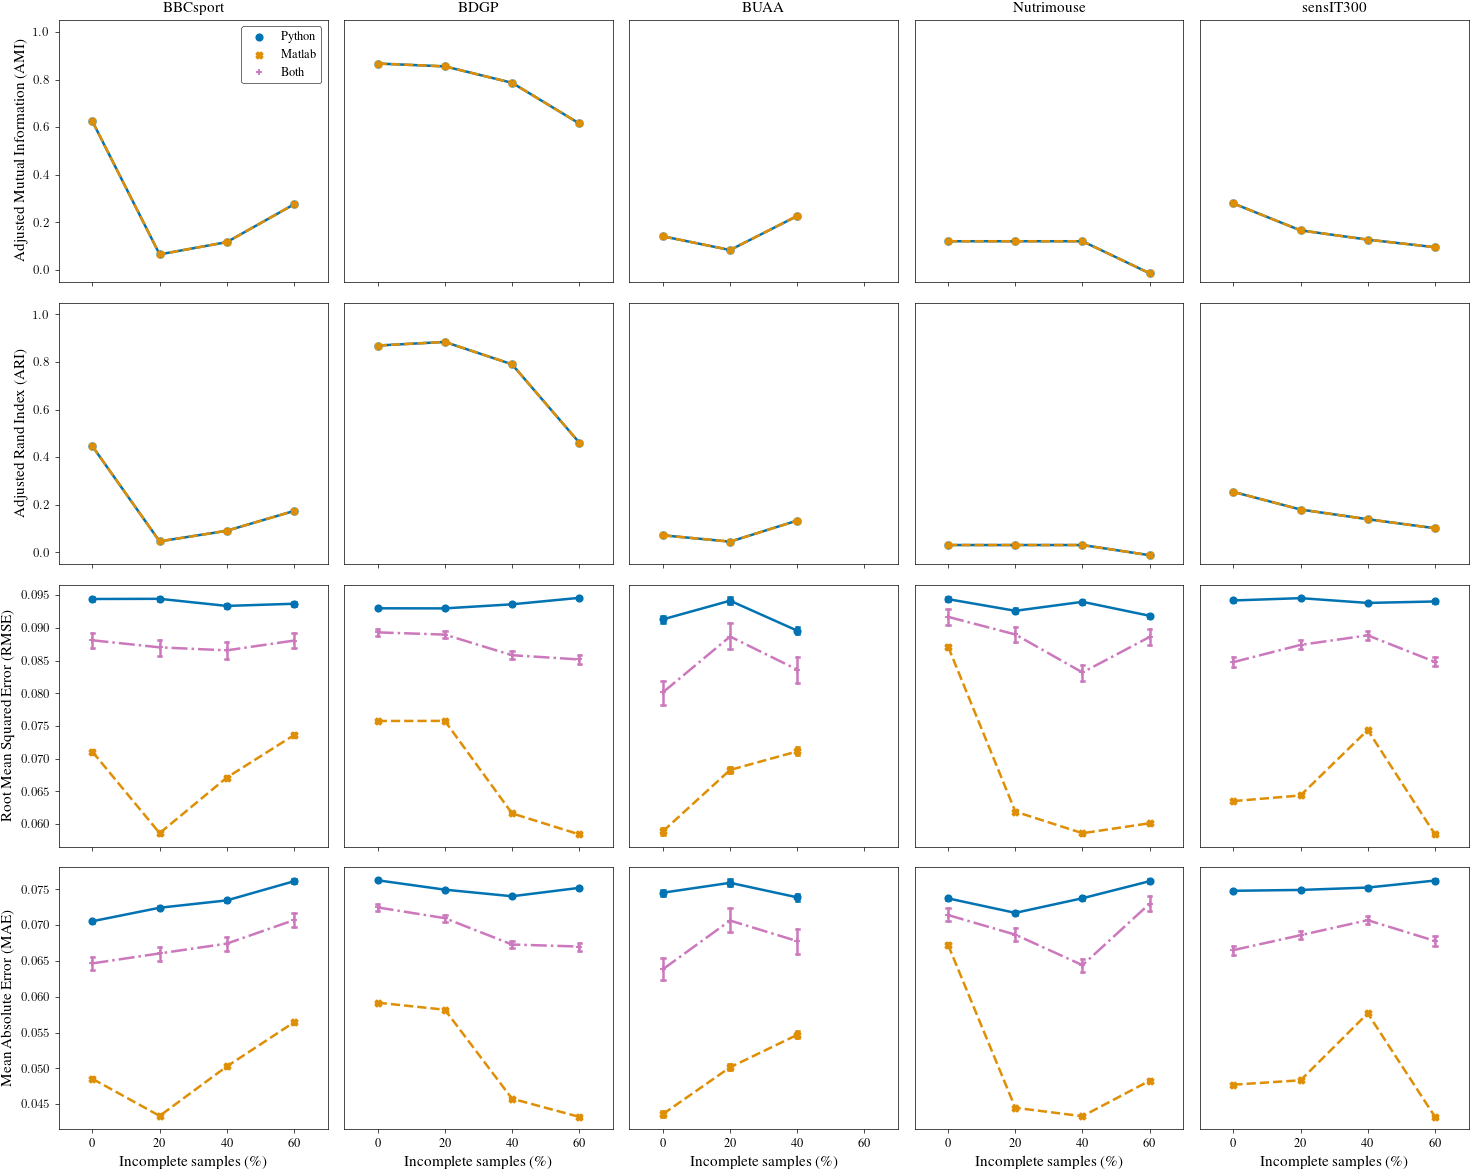

In [14]:
colorblind_palette = sns.color_palette("colorblind")
color_language_idx = 1 if language_comparison == "matlab" else 3
axes = sns.FacetGrid(data=results, row="Metric", col= "Dataset", dropna=True, legend_out=False,
                     sharey=False, despine=False).map_dataframe(
    sns.pointplot, x="Incomplete samples (\%)", y= "Value", hue= "Engine",
    palette= [colorblind_palette[0]] + [colorblind_palette[color_language_idx]] + [colorblind_palette[4]],
    hue_order=["Python", language_comparison.capitalize(), "Both"], linestyles= ["-", "--", "-."],
    markers= ["o", "X", "+"], capsize= 0.05, seed= 42)
axes.add_legend()
for ax, ylabel in zip(axes.axes[:, 0], results["Metric"].unique()):
    ax.set_ylabel(ylabel)
for ax in axes.axes.flatten():
    if ("AMI" in ax.get_title()) or ("ARI" in ax.get_title()):
        ax.set_ylim(-0.05, 1.05)
    ax.set_title("")
for ax, title in zip(axes.axes[0, :], results["Dataset"].unique()):
    ax.set_title(title)
for i in range(results["Metric"].nunique()):   
    for j in range(1, results["Dataset"].nunique()):   
        axes.axes[i,j].get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.savefig(f"engine_comparison_{estimator_name}.pdf")